In [1]:
import os

current_directory = os.getcwd()
project_directory = os.path.abspath(os.path.join(current_directory, os.pardir, os.pardir))
os.chdir(project_directory)


In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.decomposition import PCA
import pickle


def create_dataset(features_, classes_, idx_to_class):
    df = pd.DataFrame(np.concatenate([features_, classes_.reshape(-1, 1)], axis=1),
                      columns=["feature_1", "feature_2", "class"])
    df["feature_1"] = pd.to_numeric(df["feature_1"])
    df["feature_2"] = pd.to_numeric(df["feature_2"])
    df["class_name"] = df["class"].apply(lambda x: idx_to_class[int(x)])
    top_classes = df["class_name"].value_counts()[:10].index.values
    return df[df["class_name"].isin(top_classes)]

# Получение эмбеддингов resnet для картинок по брендам

In [3]:
with open("data/features/resnet152.pickle", "rb") as f:
    features, classes, class_to_idx = pickle.load(f)

In [4]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
classes_idx = classes[:, 1]

# Сжатие с помощью SVD до двух компонент

/home/seara/.pyenv/versions/3.9.16/envs/DS/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


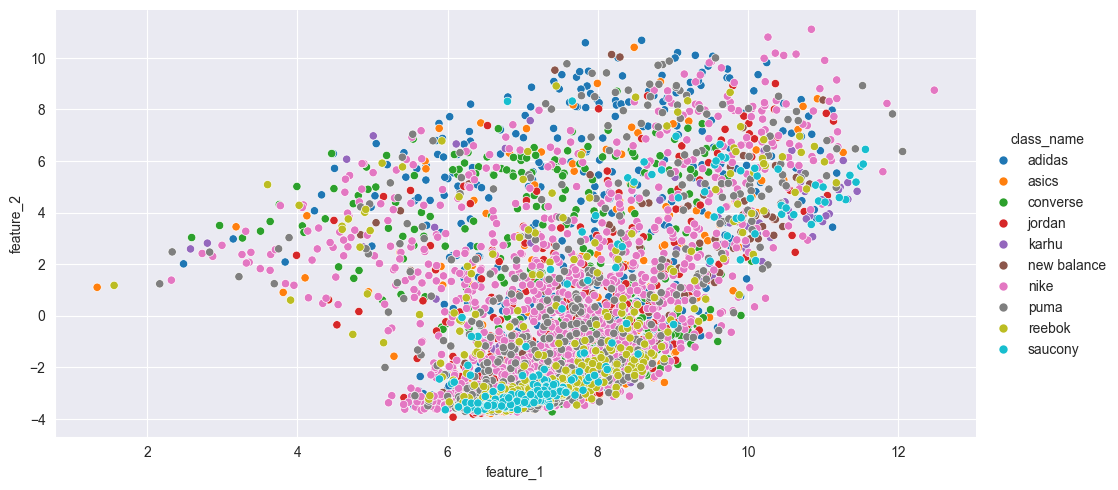

In [5]:
SVD_2 = TruncatedSVD(n_components=2).fit_transform(features)
df = create_dataset(SVD_2, classes_idx, idx_to_class)
sns.relplot(data=df, x="feature_1", y="feature_2", hue="class_name", aspect=2)

# Сжатие с помощью PCA до двух компонент

/home/seara/.pyenv/versions/3.9.16/envs/DS/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


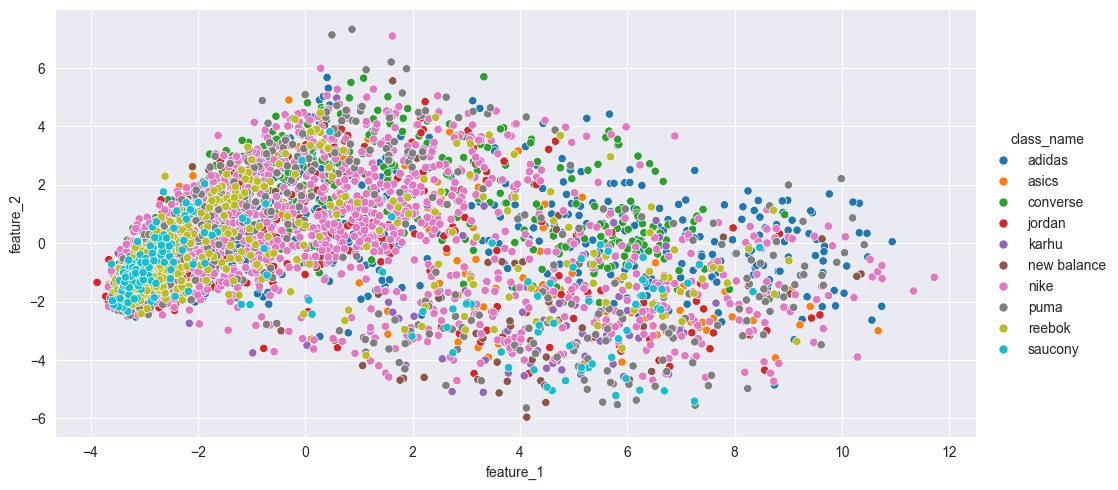

In [6]:
PCA_2 = PCA(n_components=2).fit_transform(features)
df = create_dataset(PCA_2, classes_idx, idx_to_class)
sns.relplot(data=df, x="feature_1", y="feature_2", hue="class_name", aspect=2)

# TSNE до двух компонент (сначала сжимаем с помощью PCA до 50 компонент, потом уже TSNE до двух)

/home/seara/.pyenv/versions/3.9.16/envs/DS/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


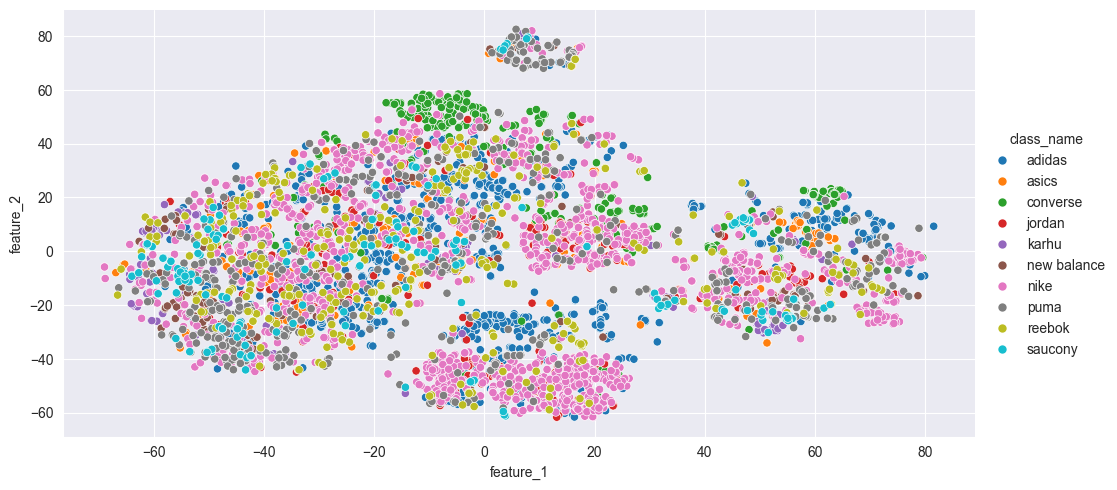

In [7]:
PCA_50 = PCA(n_components=50).fit_transform(features)
TSNE_2 = TSNE(n_components=2).fit_transform(PCA_50)
df = create_dataset(TSNE_2, classes_idx, idx_to_class)
sns.relplot(data=df, x="feature_1", y="feature_2", hue="class_name", aspect=2)

# Видны кластеры, но они не соответствуют брендам - скорее всего они кучкуются по *ракурсам* изображений.

# Посмотрим можно ли удалить дубликаты - картинки с похожими эмбеддингами

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(features)
threshold = 0.99
paths = list(classes[:,0])

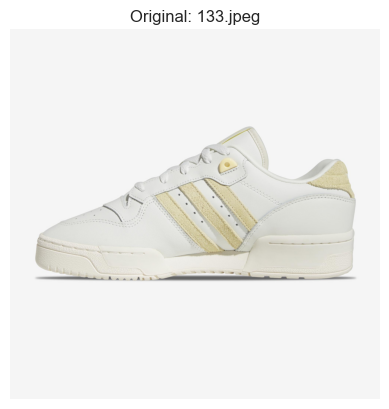

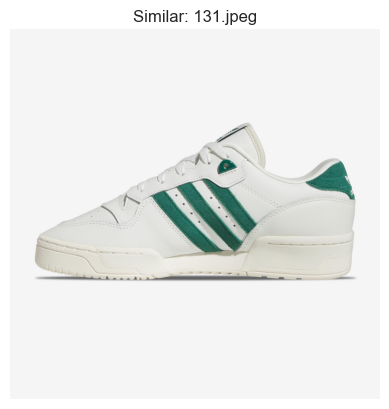

Deleted: 131.jpeg


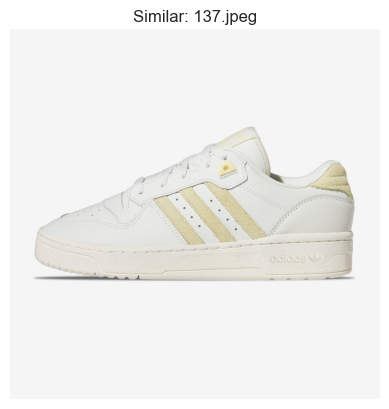

Deleted: 137.jpeg


In [13]:
import matplotlib.pyplot as plt
from PIL import Image
for i in range(len(paths)):
    similar_indices = np.where(similarity_matrix[i] > threshold)[0]

    if len(similar_indices) > 2:

        current_image_path = paths[i]
        current_image = Image.open(current_image_path)
        plt.imshow(current_image)
        plt.title(f"Original: {os.path.basename(current_image_path)}")
        plt.axis('off')
        plt.show()

        for idx in similar_indices:
            if idx != i:
                similar_image_path = paths[idx]
                similar_image = Image.open(similar_image_path)

                plt.imshow(similar_image)
                plt.title(f"Similar: {os.path.basename(similar_image_path)}")
                plt.axis('off')
                plt.show()

                print(f"Deleted: {os.path.basename(similar_image_path)}")
        break